<h1>Recipe classification and visualization</h1>
<h4><i>Clustering and visualizing recipes by ingredients</i></h4>
<h4><br></h4>
<h2><Introduction></h2>
<h4>About the data</h4>
The Food.com Recipes and Interactions dataset contains 180k+ recipes and 700k+ reviews covering 18 years of user interactions and uploads on Food.com. The dataset is available on [Kaggle](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) and originates from the paper ["Generating Personalized Recipes from Historical User Preferences"](https://www.aclweb.org/anthology/D19-1613/) by Majumder, et al. In this project, we use the raw recipe data [1].
<h4><br></h4>
<h4>Encoding ingredients with GloVe</h4>
A pre-trained GloVe network is used to generate embeddings for each recipe. The average GloVe embedding for all ingredients in a recipe is used to represent the recipe. GloVe is an unsupervised learning algorithm for obtaining vector representation for words. Training is performed on aggregated global word co-occurrence statistics and reflects linear substructures in word vector space. Two examples are shown below showcasing the relationship man and women and comparatives [2]. 

![img](comparative_superlative.jpg)
![img](man_woman.jpg)

GloVe constructs a matrix of context words with co-occurrence frequencies. This large matrix is factorized into a word-feature matrix, which contains the embedding, and a feature-context matrix. The training of the GloVe model is distinct from the Word2Vec model. The GloVe model uses global word to word co-occurrence counts while word2vec uses uses co-occurrences within a local context. However, the two encoding models capture similar relationships [3].

<h4><br></h4>
<h4>Clustering ingredients</h4>
Recipes are clustered using the KMeans clustering algorithm, which groups data into clusters. The algorithm randomly assigns centroids, assigns data to each centroid based on distance, and iteratively moves the centroid to the center of the newly defined cluster until the centroids no longer move.

<h4><br></h4>
<h4>Visualizing clusters</h4>
Clusters are visualized using several dimensionality reduction techniques, described below [4]:

- <b>t-SNE</b>: t-distributed stochastic neighbor embedding (t-SNE) reduces dimensionality while keeping similar instances close. 
- <b>MDS</b>: Multidimensional scaling (MDS) reduces dimensionality while preserving the distance between instances. 
- <b>LLE</b>: Locally linear embedding (LLE) is a non-linear dimensionality reduction technique that finds a low-dimensional representation that best preserves local relationships.
- <b>Isomap</b>: Isomap connects each instance to its nearest neighbors and preserves the number of nodes between instances.
- <b>Wordcloud</b>: Ingredient and recipe names for each cluster are visualized in a word cloud. This enable us to discern non-mathematical thematic differences between clusters. 

<h4><br></h4>
<h4>Cluster Descriptions</h4>

The eight distinct clusters contain distinct recipes, apparent in the word clouds above. 

1. Cheesy dishes
2. Baked goods
3. Desserts
4. Salads
5. Chicken 
6. Tropical fruits
7. Casseroles and pastas
8. Crock pot meals

New recipes could be automatically sorted into these categories by our clustering algorithm. 

<h2><br></h2>
<h2>Cleaning and encoding recipe data</h2>
<h3>Importing ingredients</h3>

In [1]:
import gensim.downloader as api

import pandas as pd
import re
import pickle
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud

In [2]:
def import_data():
    '''Import cleaned recipe, raw recipe and ratings data'''
    #cleaned recipes
    recipes = pd.read_csv('PP_recipes.csv')
    del recipes['i']
    del recipes['name_tokens']
    del recipes['ingredient_tokens']
    del recipes['steps_tokens']
    recipes = recipes.set_index('id')

    #ratings
    ratings = pd.read_csv('RAW_interactions.csv')
    del ratings['user_id']
    del ratings['date']
    del ratings['review']
    ratings = ratings.set_index('recipe_id')

    #raw recipe info
    raw_recipes = pd.read_csv('RAW_recipes.csv')
    del raw_recipes['contributor_id']
    del raw_recipes['submitted']
    del raw_recipes['tags']
    del raw_recipes['steps']
    del raw_recipes['description']
    raw_recipes = raw_recipes.set_index('id')

    return (recipes, raw_recipes, ratings)

In [3]:
_, raw_recipes_, _ = import_data()

<h3><br></h3>
<h3>Encoding one recipe</h3>

In [4]:
glove_model = api.load('glove-wiki-gigaword-50')

In [5]:
def clean_one_recipe(raw_ingredient_list):
    '''Separate recipe list into individual words'''
    ingredient_list = re.findall('\w+', raw_ingredient_list)
    return ingredient_list

In [6]:
def embed_one_recipe(ingredient_list):
    '''Encode a single recipe'''
    recipe_embedding = []
    for ingredient in ingredient_list:
        try:
            recipe_embedding.append(glove_model[ingredient])
        except:
            recipe_embedding.append(np.zeros((50)))
    recipe_embedding = pd.DataFrame(recipe_embedding).mean(axis=0)
    return recipe_embedding

In [7]:
list_in = raw_recipes_['ingredients'].iloc[0]
ingredient_list = clean_one_recipe(list_in)
recipe_embedding = embed_one_recipe(ingredient_list)
recipe_embedding.head()

0   -0.322388
1    0.215897
2   -0.863623
3    0.342868
4    0.282728
dtype: float32

<h3><br></h3>
<h3>Encoding all recipes</h3>

In [8]:
test_range = None

In [9]:
raw_recipes_.shape

(231637, 6)

In [10]:
def timer_func(func):
    '''Wrapper function to time functions'''
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [11]:
@timer_func
def encode_recipes():
    '''Encode all recipes'''
    recipe_embeddings = []
    for recipe in raw_recipes_['ingredients'][:test_range]:
        ingredient_list = clean_one_recipe(recipe)
        recipe_embeddings.append(embed_one_recipe(ingredient_list))
    return pd.DataFrame(recipe_embeddings)

In [12]:
encoded_recipes = encode_recipes()

Function 'encode_recipes' executed in 120.5984s


In [13]:
encoded_recipes.shape

(231637, 50)

In [14]:
encoded_recipes.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.322388,0.215897,-0.863623,0.342868,0.282728,0.033896,-0.299164,0.145410,-0.023604,0.146014,...,0.273791,0.083687,0.201765,-0.458108,0.748384,0.772295,0.002920,-0.027175,-0.158647,-0.238712
1,0.117049,-0.105789,-0.623373,-0.088335,0.422369,0.864983,-0.313520,0.247731,-0.134833,-0.170577,...,0.644464,0.024751,-0.037983,-0.130208,0.796528,0.849185,-0.199121,-0.088433,-0.238068,0.095297
2,0.031537,-0.195235,-0.472846,0.085179,0.377397,0.272177,-0.133702,-0.080536,-0.099638,-0.011087,...,0.545620,-0.013276,-0.004070,-0.300977,1.176739,0.976502,0.173980,0.092145,0.171500,-0.064618
3,-0.004873,0.243860,-0.687108,0.118598,0.544544,0.371865,-0.158334,-0.048740,-0.333201,-0.064658,...,0.780880,0.144425,0.014742,-0.467413,0.855446,1.010961,-0.023708,-0.193350,-0.302259,-0.083789
4,-0.197585,-0.142786,-0.491921,0.429796,0.255868,0.168091,-0.099953,0.095028,0.164880,0.342105,...,0.634047,-0.039552,-0.113946,-0.497591,0.772490,1.113699,-0.143467,-0.117670,-0.139136,-0.264278


In [15]:
encoded_recipes = encoded_recipes[:test_range]

<h2><br></h2>
<h2>Clustering recipes</h2>
<h3> Selecting cluster number</h3>

In [16]:
@timer_func
def batch_cluster(X_pca,cluster_start=2, cluster_stop=50, cluster_skip=10):    
    '''Clusters data using mini-batch Kmeans'''
    k_range = np.arange(cluster_start,cluster_stop,cluster_skip)
    kmeans = [MiniBatchKMeans(n_clusters = k, n_init=100, random_state=10).fit(X_pca) for k in k_range]
    inertia = [kmeans.inertia_ for kmeans in kmeans]
    labels = [kmeans.labels_ for kmeans in kmeans]
    s_scores = [silhouette_score(X_pca, kmeans_.labels_) for kmeans_ in kmeans]
    return k_range, kmeans, inertia, labels, s_scores

In [17]:
k_range, kmeans, inertia, labels, s_scores = batch_cluster(encoded_recipes, cluster_stop = 21, cluster_skip = 1)

KeyboardInterrupt: 

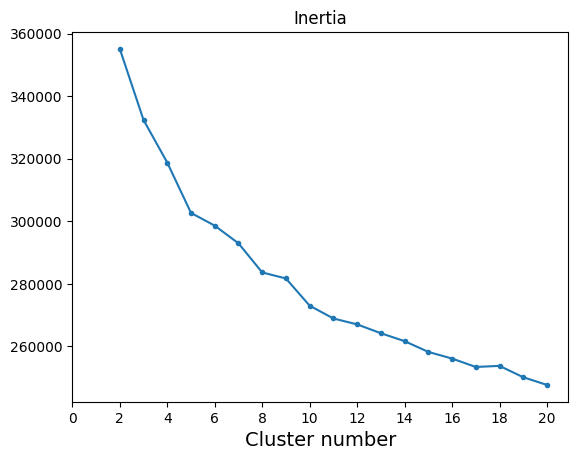

In [ ]:
plt.plot(k_range,inertia,'.-')
plt.xlabel('Cluster number', fontsize=14)
#plt.ylabel('Inertia', fontsize=14)
plt.title('Inertia')
plt.xticks(np.arange(0,21,2))
plt.show()

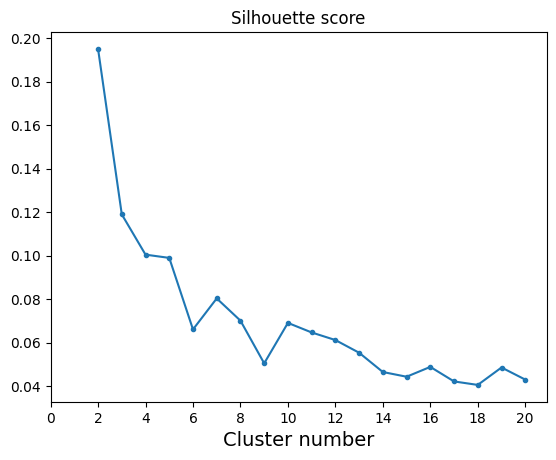

In [ ]:
plt.plot(k_range,s_scores,'.-')
plt.xlabel('Cluster number', fontsize=14)
#plt.ylabel('Silhoette score', fontsize=14)
plt.xticks(np.arange(0,21,2))
plt.title('Silhouette score')
plt.show()

<h3><br></h3>
<h3>Selected cluster labels</h3>

In [ ]:
#select clusdter number and add cluster ID to embeddings
CLUSTER_NUM = 8
labels_ = labels[CLUSTER_NUM-2]
#encoded_recipes['Cluster ID'] = labels_

<h2><br></h2>
<h2>Visualizing clusters</h3>

In [ ]:
encoded_recipes.columns = encoded_recipes.columns.astype(str)
visual_names = ['t-TSNE','Locally linear embedding','Multidimensional scaling','Isomap']
visual_models = [
    TSNE(n_components=2,n_jobs=-1),
    LLE(n_components=2, n_neighbors=10, n_jobs=-1),
    MDS(n_components=2, normalized_stress='auto',n_jobs=-1),
    Isomap(n_jobs=-1)
]

In [ ]:
for name,model in zip(visual_names,visual_models):
    X_reduced = model.fit_transform(encoded_recipes[:10_000])
    X_reduced = pd.DataFrame(X_reduced, columns=['1','2'])
    X_reduced['Cluster ID'] = labels_

    sns.scatterplot(data=X_reduced, x='1',y='2',hue='Cluster ID',palette='Spectral')
    plt.title(name, fontsize=18)
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

<h3></br></h3>
<h3>Word clouds</h3>

In [ ]:
cloud_names = ['Cheese dishes', 'Baked goods', 'Desserts', 'Salads', 'Chicken', 'Tropical fruits', 'Casseroles and pastas', 'Crockpot meals']

In [ ]:
count = 1
def show_cloud(embeded_recipes,raw_recipes_,key):
    raw_recipes_ = raw_recipes_.iloc[:test_range,:]
    raw_recipes_['Cluster_ID']=labels_
    plt.figure(figsize=(6,10))
    for k in range(CLUSTER_NUM):
        df_k = raw_recipes_[raw_recipes_['Cluster_ID']==k][key]
        list_k = df_k.to_list()
        cluster_ingred = ''
        for ingredients in list_k:
            if key == 'ingredients':
                cleaned_ingredients = clean_one_recipe(ingredients)
                cleaned_ingredients = ' '.join(cleaned_ingredients)
            else: 
                cleaned_ingredients = str(ingredients)
                cleaned_ingredients = cleaned_ingredients.replace(' s ','')
            cluster_ingred += cleaned_ingredients+' '
        wordcloud = WordCloud().generate(cluster_ingred)
        plt.subplot(5,2,k+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(cloud_names[k])
    plt.tight_layout()

In [ ]:
show_cloud(encoded_recipes,raw_recipes_,'ingredients')

In [ ]:
show_cloud(encoded_recipes,raw_recipes_,'name')

<h2><br></h2>
<h2>Works referenced</h2>

1. paper
2. Pennington, J., Socher, R., Manning, C.D. "GLoVe: Global Vectors for Word Representation." <i>Standard University</i>. Aug. 2014. https://nlp.stanford.edu/projects/glove.
3. MLNerds. "What is the difference between word2Vec and GloVe?" Feb. 2019. https://machinelearninginterview.com/topics/natural-language-processing/what-is-the-difference-between-word2vec-and-glove/.
4. Geron, A. <i>Hands-On Machine Learning with Scikit-Learn</i>, Keras & TensorFlow. 3rd Edition. O'Reilly, 2023. pg. 254-257.